Лабораторная работа №2. Введение в проектирование нейронных сетей с помощью Python

In [1209]:
"""
https://github.com/vedaant-varshney/ImageClassifierCNN/blob/master/Image%20Classifier.ipynb
"""

from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.backends.cudnn

torch.cuda.synchronize()
torch.cuda.empty_cache()

torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = True

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("cuDNN benchmark?", torch.backends.cudnn.benchmark)
print("is Use Deterministic Algorithms?", torch.backends.cudnn.deterministic)

cuda = torch.device('cuda')
print(torch.cuda.get_device_properties(cuda))

Is cuda available? True
Is cuDNN version: 8302
cuDNN enabled?  True
cuDNN benchmark? True
is Use Deterministic Algorithms? False
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Laptop GPU', major=8, minor=6, total_memory=8191MB, multi_processor_count=48)


In [1210]:
# mnist_train = np.genfromtxt(f"dataset/mnist_train.csv", delimiter=',', dtype=np.uint8)
# mnist_test = np.genfromtxt(f"dataset/mnist_test.csv", delimiter=',', dtype=np.uint8)

mnist_train = pd.read_csv(f"dataset/mnist_train.csv", header=None, engine="c", delimiter=',', dtype=np.uint8).to_numpy()
mnist_test = pd.read_csv(f"dataset/mnist_test.csv", header=None, engine="c", delimiter=',', dtype=np.uint8).to_numpy()

In [1211]:
print(mnist_train.shape)
print(mnist_test.shape)

images_train = np.float32(np.reshape(mnist_train[:, 1:], (mnist_train.shape[0], 28, 28, 1))) / 255
numbers_train = mnist_train[:, 0]
images_test = np.float32(np.reshape(mnist_test[:, 1:], (mnist_test.shape[0], 28, 28, 1))) / 255
numbers_test = mnist_test[:, 0]

images_train = np.transpose(images_train, [0, 3, 1, 2])
images_test = np.transpose(images_test, [0, 3, 1, 2])

images_train = torch.tensor(images_train, device=cuda).to(non_blocking=True)
numbers_train = torch.tensor(numbers_train, device=cuda).to(non_blocking=True)
images_test = torch.tensor(images_test, device=cuda).to(non_blocking=True)
numbers_test = torch.tensor(numbers_test, device=cuda).to(non_blocking=True)

print(images_train.shape)
print(numbers_train.shape)
print(images_test.shape)
print(numbers_test.shape)

print("Классы: ", np.unique(numbers_train.cpu()))

(60000, 785)
(10000, 785)
torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])
Классы:  [0 1 2 3 4 5 6 7 8 9]


In [1212]:
"""
number_train = random.randint(0, images_test.cpu().shape[0])
plt.imshow(images_test.cpu()[number_train, 0, :, :], cmap=plt.cm.binary, vmin=0, vmax=1)
plt.title(f"Число из обучающего датасета: {numbers_test.cpu().numpy()[number_train]}")
print()
"""

'\nnumber_train = random.randint(0, images_test.cpu().shape[0])\nplt.imshow(images_test.cpu()[number_train, 0, :, :], cmap=plt.cm.binary, vmin=0, vmax=1)\nplt.title(f"Число из обучающего датасета: {numbers_test.cpu().numpy()[number_train]}")\nprint()\n'

In [1213]:
"""
number_test = random.randint(0, images_test.cpu().shape[0])
plt.imshow(images_test.cpu()[number_test, 0, :, :], cmap=plt.cm.binary, vmin=0, vmax=1)
plt.title(f"Число из тестового датасета: {numbers_test.cpu().numpy()[number_test]}")
print()
"""

'\nnumber_test = random.randint(0, images_test.cpu().shape[0])\nplt.imshow(images_test.cpu()[number_test, 0, :, :], cmap=plt.cm.binary, vmin=0, vmax=1)\nplt.title(f"Число из тестового датасета: {numbers_test.cpu().numpy()[number_test]}")\nprint()\n'

In [1214]:
print(images_train.shape)
print(numbers_train.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [1215]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
import model_architecture
reload(model_architecture)

# Picking Fashion-MNIST dataset

num_workers = 0
batch_size = 100
valid_size = 0.2

train_transforms = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomInvert(p=0.5),
])
normalize_transforms = transforms.Compose([
    transforms.Resize(size=model_architecture.IMAGE_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize((0.5,), (0.5,)),
])

train_data = TensorDataset(images_train, numbers_train)
test_data = TensorDataset(images_test, numbers_test)

# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))
#Randomize indices
np.random.shuffle(indices)

split = int(np.floor(num_train * valid_size))
train_index, test_index = indices[split:], indices[:split]

# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Image classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

torch.Size([100, 1, 28, 28]) torch.Size([100]) 6


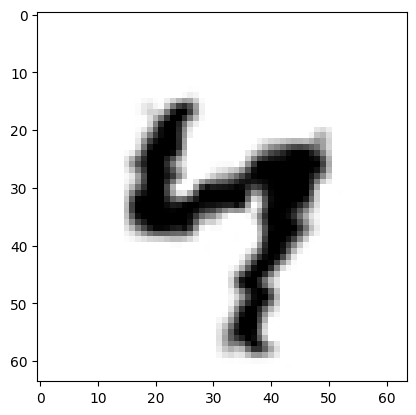

In [1216]:
for batch_index, (data, target) in enumerate(train_loader):
    break
print(data.shape, target.shape, classes[target[0]])
image = normalize_transforms(train_transforms(data.cpu()))

plt.imshow(image[random.randint(0, image.shape[0]), 0, :, :], cmap=plt.cm.binary, vmin=-1, vmax=1)

In [1217]:
from importlib import reload
import model_architecture
reload(model_architecture)

import torch.optim as optim


model = model_architecture.Net()
model.cuda()
print(model)

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.05)

train_losses = []
valid_losses = []

Net(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (

Current Epoch: 10
Training Loss: 0.068745
Validation Loss: 0.087545


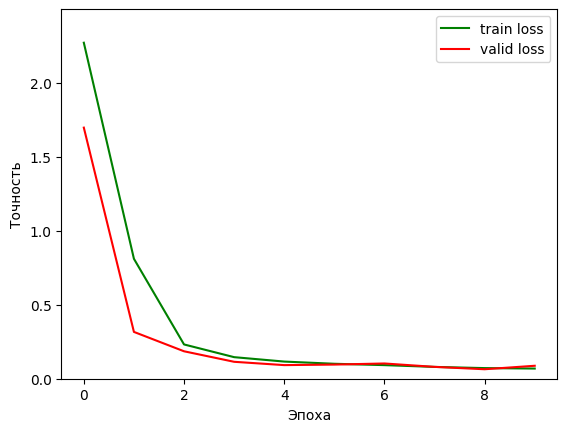

In [1218]:
# epochs to train for
epochs = 10

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf

for epoch in range(1, epochs + 1):
    clear_output(wait=True)

    train_loss = 0
    valid_loss = 0

    # training steps
    model.train()

    index = 0
    for batch_index, (data, target) in enumerate(train_loader):
        index += 1
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(normalize_transforms(train_transforms(data)))
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # forward pass
        output = model(normalize_transforms(train_transforms(data)))
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item() * data.size(0)

    # average loss calculations
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

    plt.plot(train_losses, 'g')
    plt.plot(valid_losses, 'r')
    plt.ylim([0, max(np.max(np.array(train_losses)), np.max(np.array(train_losses)), 0.0) * 1.1])
    plt.xlabel("Эпоха")
    plt.ylabel("Точность")
    plt.legend(["train loss", "valid loss"])
    plt.show()

In [1219]:
from importlib import reload
import model_architecture
import torch.optim as optim

reload(model_architecture)

model_new = model_architecture.Net()
model_new.cuda()
model_new.load_state_dict(torch.load('trained_model.pt'))

<All keys matched successfully>

In [1220]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_new.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU
    data, target = data.cuda(), target.cuda()
    # forward pass
    output = model_new(normalize_transforms(train_transforms(data)))

    output_max = torch.max(output)
    output_min = torch.min(output)

    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
        correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(28):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {round(test_loss, 6)}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {round(100 * class_correct[i] / class_total[i], 2)}%')
    else:
        print(f'Test Accuracy of {classes[i]}s: N/A (no training examples)')

print(
    f'Full Test Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} out of {np.sum(class_total)}')

output_min = output_min.cpu().detach().numpy()
output_max = output_max.cpu().detach().numpy()

torch.Size([100, 64, 2, 2])
Test Loss: 0.059814
Test Accuracy of 0: 100.0%
Test Accuracy of 1: 99.37%
Test Accuracy of 2: 97.4%
Test Accuracy of 3: 97.92%
Test Accuracy of 4: 98.6%
Test Accuracy of 5: 99.57%
Test Accuracy of 6: 97.63%
Test Accuracy of 7: 95.1%
Test Accuracy of 8: 96.79%
Test Accuracy of 9: 97.23%
Full Test Accuracy: 97.93% 2742.0 out of 2800.0


In [1221]:
prediction_threshold_amount = 100

In [1222]:
prediction_threshold_low = []

while len(prediction_threshold_low) < prediction_threshold_amount:
    for batch_idx, (data, target) in enumerate(train_loader):
        clear_output(wait=True)
        data = normalize_transforms(train_transforms(data))
        output = model_new(data[:1, :1, :, :]).cpu().detach()
        output = (output.numpy()[0] - output_min) / (output_max - output_min)
        if target[0] == np.argmax(output):
            continue
        prediction_threshold_low.append(np.max(output))
        print(f"calibration lower threshold {100 * len(prediction_threshold_low) / prediction_threshold_amount:.2f}%")
        print(f"real value = {target[0]}")
        print(f"prediction = {np.argmax(output)}")
        print(f"prediction % = {np.max(output)}")
        print(f"predictions = {output}")
        plt.imshow(data.cpu()[0, 0, :, :], cmap=plt.cm.binary, vmin=-1, vmax=1)
        plt.show()
        if len(prediction_threshold_low) >= prediction_threshold_amount:
            break

threshold_low = np.mean(np.array(prediction_threshold_low))

clear_output(wait=True)
print(f"lower threshold = {threshold_low}")

lower threshold = 0.5743429064750671


In [1223]:
prediction_threshold_high = []

while len(prediction_threshold_high) < prediction_threshold_amount:
    for batch_idx, (data, target) in enumerate(train_loader):
        clear_output(wait=True)
        data = normalize_transforms(train_transforms(data))
        output = model_new(data[:1, :1, :, :]).cpu().detach()
        output = (output.numpy()[0] - output_min) / (output_max - output_min)
        prediction_threshold_high.append(np.max(output))
        print(f"calibration upper threshold {100 * len(prediction_threshold_high) / prediction_threshold_amount:.2f}%")
        print(f"real value = {target[0]}")
        print(f"prediction = {np.argmax(output)}")
        print(f"prediction % = {np.max(output)}")
        print(f"predictions = {output}")
        plt.imshow(data.cpu()[0, 0, :, :], cmap=plt.cm.binary, vmin=-1, vmax=1)
        plt.show()
        if len(prediction_threshold_high) >= prediction_threshold_amount:
            break

threshold_high = np.mean(np.array(prediction_threshold_high))

clear_output(wait=True)
print(f"upper threshold = {threshold_high}")

upper threshold = 0.7724108099937439


In [1224]:
confidence_threshold = threshold_high / 2 + threshold_low / 2
print(f"final confidence threshold = {confidence_threshold}")
print(f"from {threshold_low} => to {threshold_high}")
print(f"window = {threshold_high - threshold_low}")

final confidence threshold = 0.6733768582344055
from 0.5743429064750671 => to 0.7724108099937439
window = 0.19806790351867676
